# Jul 5th, 2022 (Fig-3 OCs -- draft)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.mouse import Mice
from model.configuration import Config
from analysis.similarity import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig3_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs

## Prepare (512)

In [3]:
mice = Mice(nn)
task = 'rest'

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)

props_bo['num_k'] += 1
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    BOLD: bt_bo,
    CAS: bt_cas,
    CAF: bt_caf,
}

## OCs

In [4]:
kws_show = {
    'vmin': 0.2,
    'vmax': 1.0,
    'mask_thresh': 1 / num_k,
    'ylabel_fontsize': 20,
    'add_disjoint': True,
    'figsize': (40, 5),
}

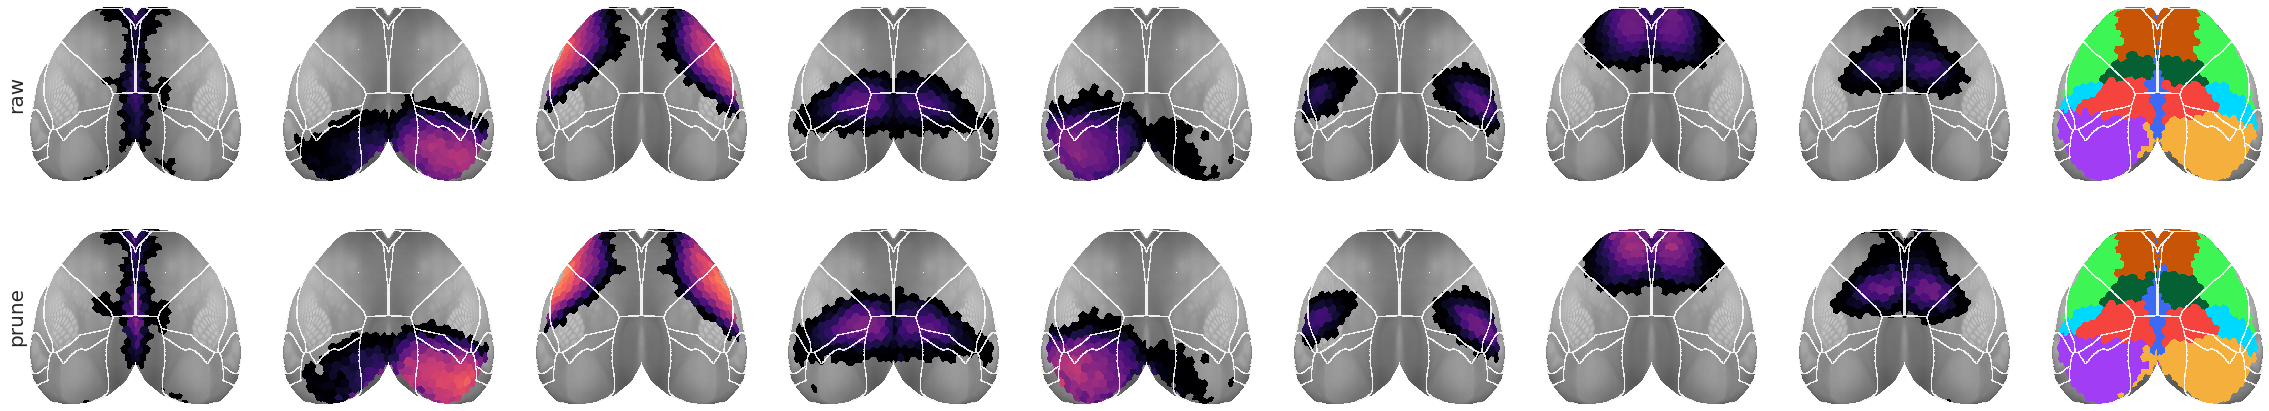

In [5]:
kws_show['figsize'] = (40, 7.5)
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

## MG (latest)

### Find best threshold (but remove pi <= 1 / num_k)

In [6]:
%%time

dlist = []
for thres in np.linspace(0.3, 0.5, 101):
    pi, *_ = bt_bo.merge_vis(thres, bt_bo.run_pi)
    pi = avg(pi)
    pi[pi < 1 / num_k] = 0
    ovp, disj = bt.symmetry_score(pi, decimals=10)
    for lbl, s in {'ovp': ovp, 'disj': disj}.items():
        dlist.append({
            'thres': [thres] * len(s),
            'label': [lbl] * len(s),
            'score': s.values(),
            'oc_idx': s.keys(),
        })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 5min 55s, sys: 1min 11s, total: 7min 6s
Wall time: 7min 6s


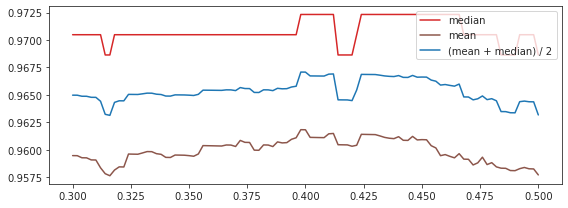

In [7]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

fig, ax = create_figure(1, 1, (8, 3))
ax.plot(df_median['thres'], df_median['score'], color='C3', label='median')
ax.plot(df_mean['thres'], df_mean['score'], color='C5', label='mean')

df_mean['score'] = (df_mean['score'] + df_median['score']) / 2
ax.plot(df_mean['thres'], df_mean['score'], color='C0', label='(mean + median) / 2')
ax.legend()
plt.show()

In [8]:
i = df_mean['score'].argmax()
df_mean.iloc[[i]]

,thres,score
49,0.398,0.967076


In [9]:
thres = df_mean.iloc[i]['thres']
thres

0.398

### Find best threshold

In [10]:
%%time

dlist = []
for thres in np.linspace(0.3, 0.5, 101):
    pi, *_ = bt_bo.merge_vis(thres, bt_bo.run_pi)
    ovp, disj = bt.symmetry_score(avg(pi), decimals=10)
    for lbl, s in {'ovp': ovp, 'disj': disj}.items():
        dlist.append({
            'thres': [thres] * len(s),
            'label': [lbl] * len(s),
            'score': s.values(),
            'oc_idx': s.keys(),
        })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 5min 55s, sys: 1min 11s, total: 7min 6s
Wall time: 7min 6s


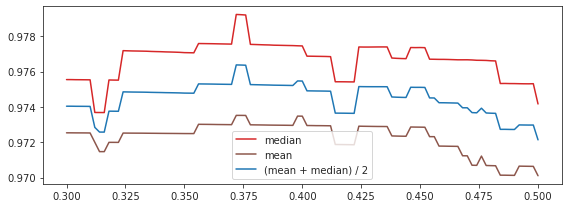

In [11]:
df_mean = df.loc[df['oc_idx'] != -1].groupby(['thres']).mean().drop(columns='oc_idx').reset_index()
df_median = df.loc[df['oc_idx'] != -1].groupby(['thres']).median().drop(columns='oc_idx').reset_index()

fig, ax = create_figure(1, 1, (8, 3))
ax.plot(df_median['thres'], df_median['score'], color='C3', label='median')
ax.plot(df_mean['thres'], df_mean['score'], color='C5', label='mean')

df_mean['score'] = (df_mean['score'] + df_median['score']) / 2
ax.plot(df_mean['thres'], df_mean['score'], color='C0', label='(mean + median) / 2')
ax.legend()
plt.show()

In [12]:
i = df_mean['score'].argmax()
df_mean.iloc[[i]]

,thres,score
36,0.372,0.976379


In [13]:
thres = df_mean.iloc[i]['thres']
thres

0.372

### Decide which threshold is to be used

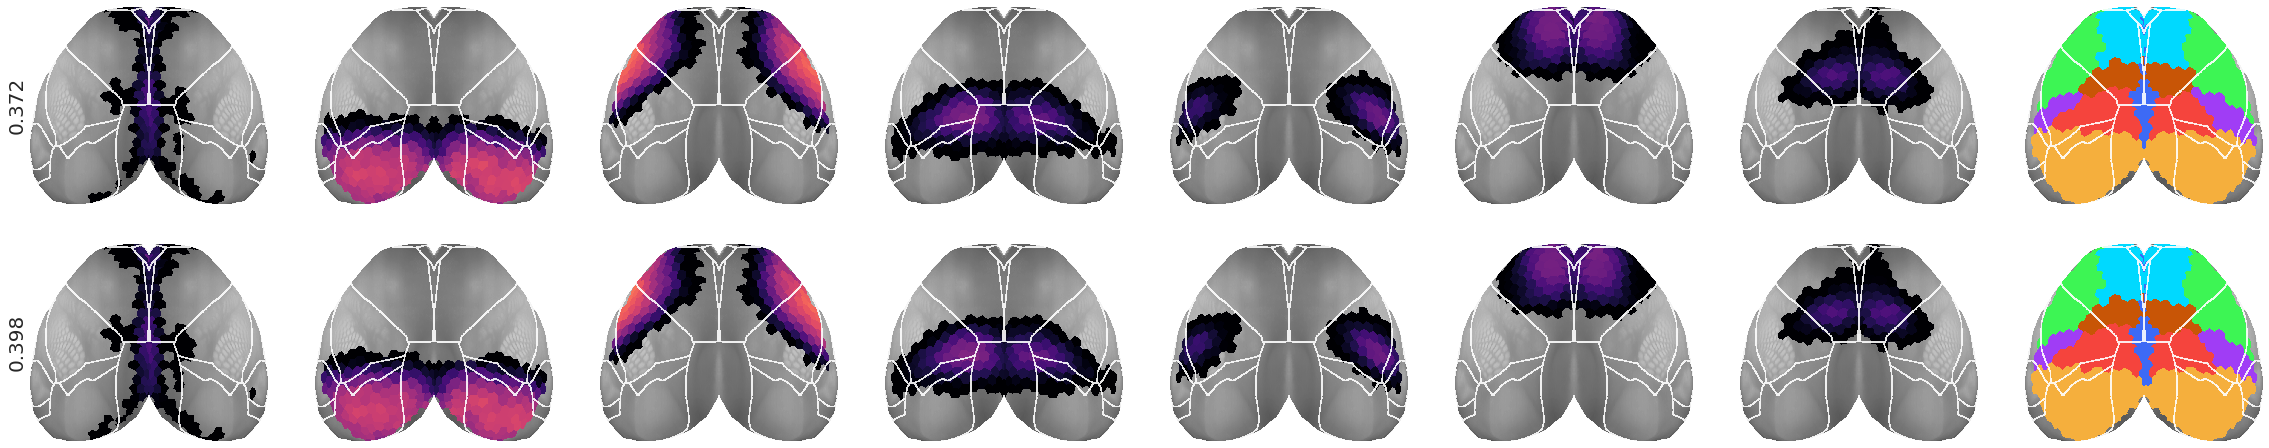

In [14]:
kws_show['figsize'] = (40, 8)
_ = bt.show(
    data={
        th: avg(bt_bo.merge_vis(th, bt_bo.run_pi)[0])
        for th in [0.372, 0.398]},
    **kws_show,
)

### It has been decided: 0.372

In [15]:
thres

0.372

In [16]:
bt_bo.run_pi, *_ = bt_bo.merge_vis(thres, bt_bo.run_pi)
bt_bo.pi_prune, *_ = bt_bo.merge_vis(thres, bt_bo.pi_prune)
bt_bo.num_k -= 1

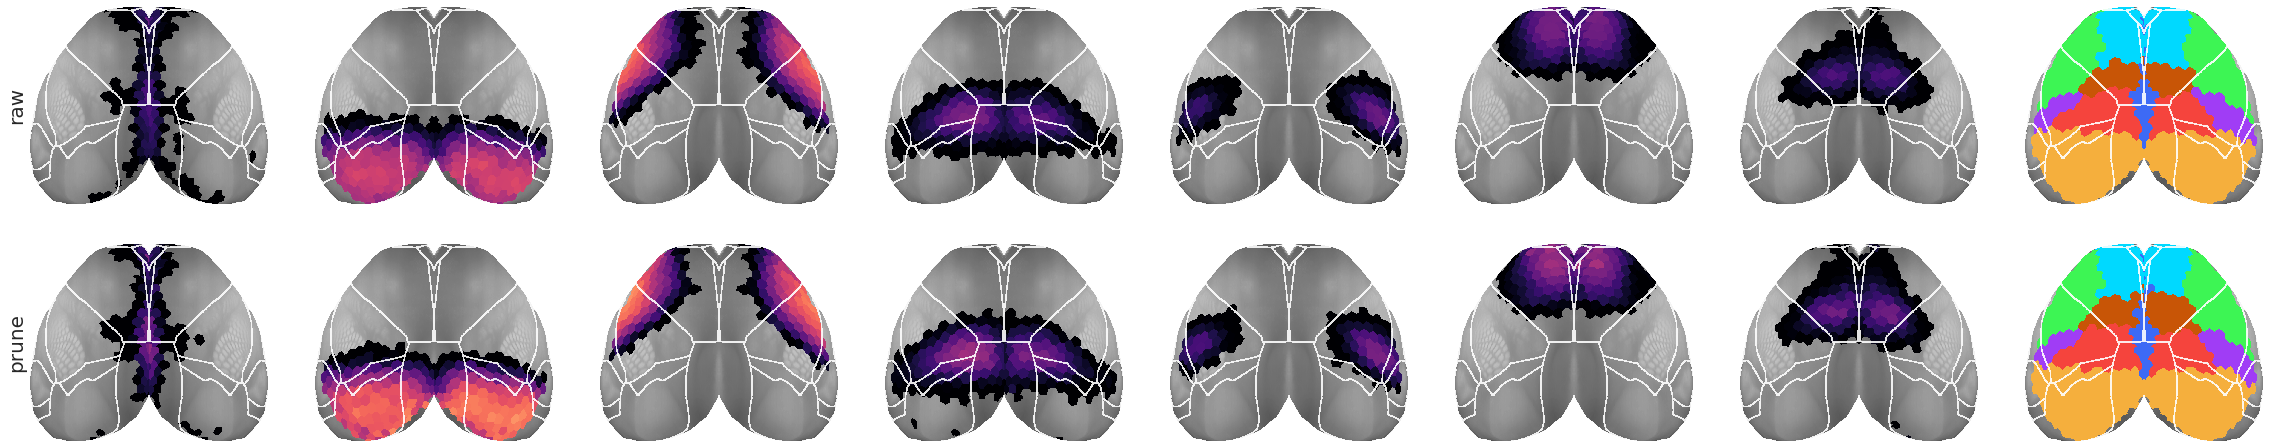

In [17]:
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

## Find best num seeds

In [18]:
%%time

dlist = []
for mode, o in bt_dict.items():
    n_seeds = o.run_pi.shape[-3]
    for i in range(0, n_seeds):
        pi = o._get_pi_seed_idx(i, use_prune=False)
        pi = avg(pi)
        
        ovp, disj = o.symmetry_score(pi, decimals=10)
        for lbl, s in {'ovp': ovp, 'disj': disj}.items():
            dlist.append({
                'mode': [mode] * len(s),
                'label': [lbl] * len(s),
                'tag': ['full'] * len(s),
                'seed': [i] * len(s),
                'score': s.values(),
                'oc_idx': s.keys(),
            })
            
        pi[pi < 1 / num_k] = 0
        ovp, disj = o.symmetry_score(pi, decimals=10)
        for lbl, s in {'ovp': ovp, 'disj': disj}.items():
            dlist.append({
                'mode': [mode] * len(s),
                'label': [lbl] * len(s),
                'tag': ['zeroed'] * len(s),
                'seed': [i] * len(s),
                'score': s.values(),
                'oc_idx': s.keys(),
            })

df = pd.DataFrame(merge_dicts(dlist))
df = df.loc[df['oc_idx'] != -1]

CPU times: user 4min 39s, sys: 1min 17s, total: 5min 56s
Wall time: 5min 56s


In [19]:
df_mean = df.groupby(['seed', 'mode', 'tag']).mean().drop(columns=['oc_idx']).reset_index()
df_median = df.groupby(['seed', 'mode', 'tag']).median().drop(columns=['oc_idx']).reset_index()

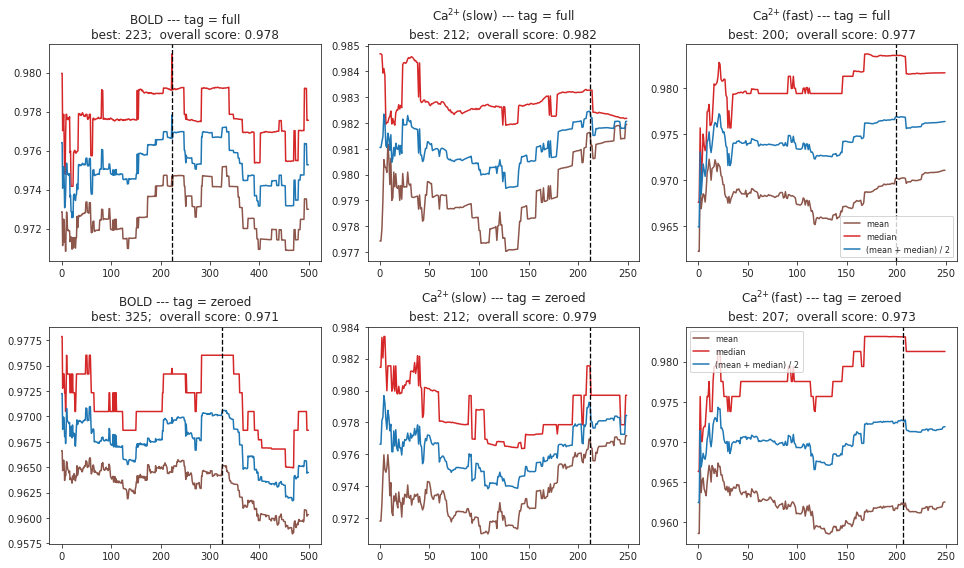

In [20]:
best_num_seeds = {}

fig, axes = create_figure(2, len(bt_dict), (13.5, 8))
for j, tag in enumerate(df['tag'].unique()):
    for i, (mode, o) in enumerate(bt_dict.items()):
        ax = axes[j, i]
        _df_mean = df_mean.loc[
            (df_mean['mode'] == mode) &
            (df_mean['tag'] == tag)

        ]
        _df_median = df_median.loc[
            (df_median['mode'] == mode) &
            (df_median['tag'] == tag)
        ]

        ax.plot(_df_mean['seed'], _df_mean['score'], color='C5', label='mean')
        ax.plot(_df_median['seed'], _df_median['score'], color='C3', label='median')

        overall = (_df_mean['score'] + _df_median['score']) / 2
        ax.plot(_df_mean['seed'], overall, color='C0', label='(mean + median) / 2')

        delta = o.run_pi.shape[-3] // 3
        idx = overall[delta:].argmax()
        idx += delta
        best_seed_i = _df_mean.iloc[idx]['seed']
        best_num_seeds[mode] = best_seed_i

        ax.axvline(best_seed_i, color='k', ls='--', lw=1.3)

        ax.set_title(f"{mode} --- tag = {tag}\nbest: {best_seed_i};  overall score: {overall.iloc[idx]:0.3f}")
        if i == 2:
            ax.legend(fontsize=8)

plt.show()

In [21]:
best_num_seeds

{'BOLD': 325, 'Ca$^{2\\!\\!+}$(slow)': 212, 'Ca$^{2\\!\\!+}$(fast)': 207}

## Sort

### First, using best seeds

In [23]:
pi_dict = {
    mode: avg(o._get_pi_seed_idx(best_num_seeds[mode], use_prune=False))
    for mode, o in bt_dict.items()
}
pi_sorted, gmaps = sort_communities(
    pi_dict=pi_dict,
    global_order=('infer', False),
    match_metric='correlation',
    bold_as_src=True,
)

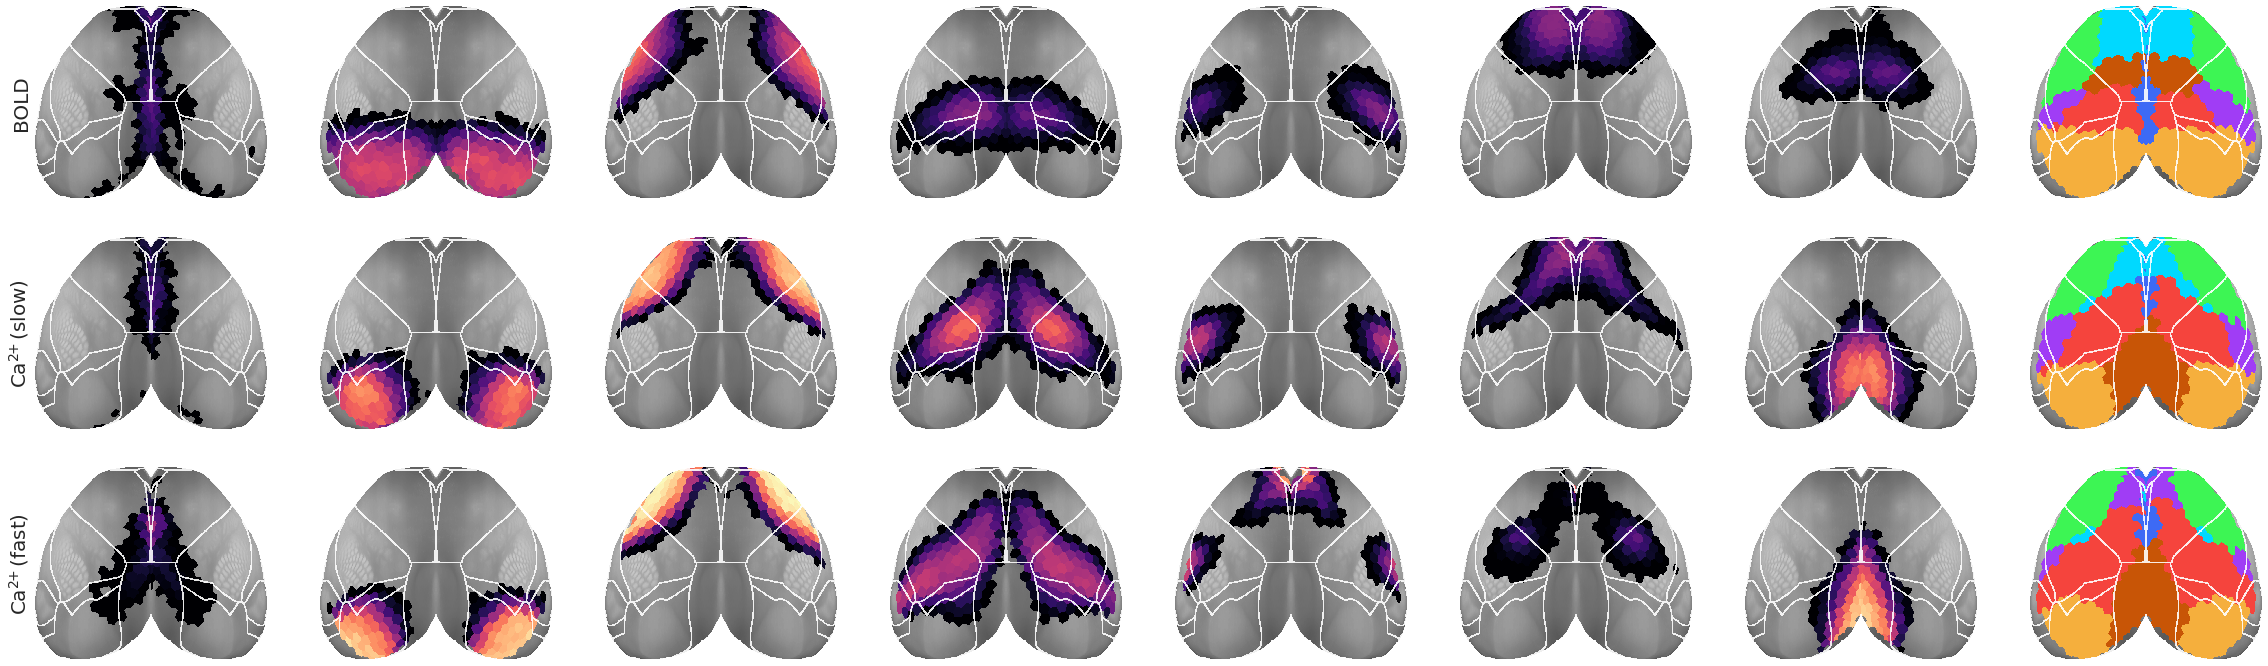

In [24]:
kws_show['figsize'] = (40, 12)
_ = bt.show(
    data=pi_sorted,
    **kws_show,
)

### Final: using all seeds

In [25]:
pi_dict = {
    mode: avg(o.run_pi) for
    mode, o in bt_dict.items()
}
pi_sorted, gmaps = sort_communities(
    pi_dict=pi_dict,
    global_order=('infer', False),
    match_metric='correlation',
    bold_as_src=True,
)

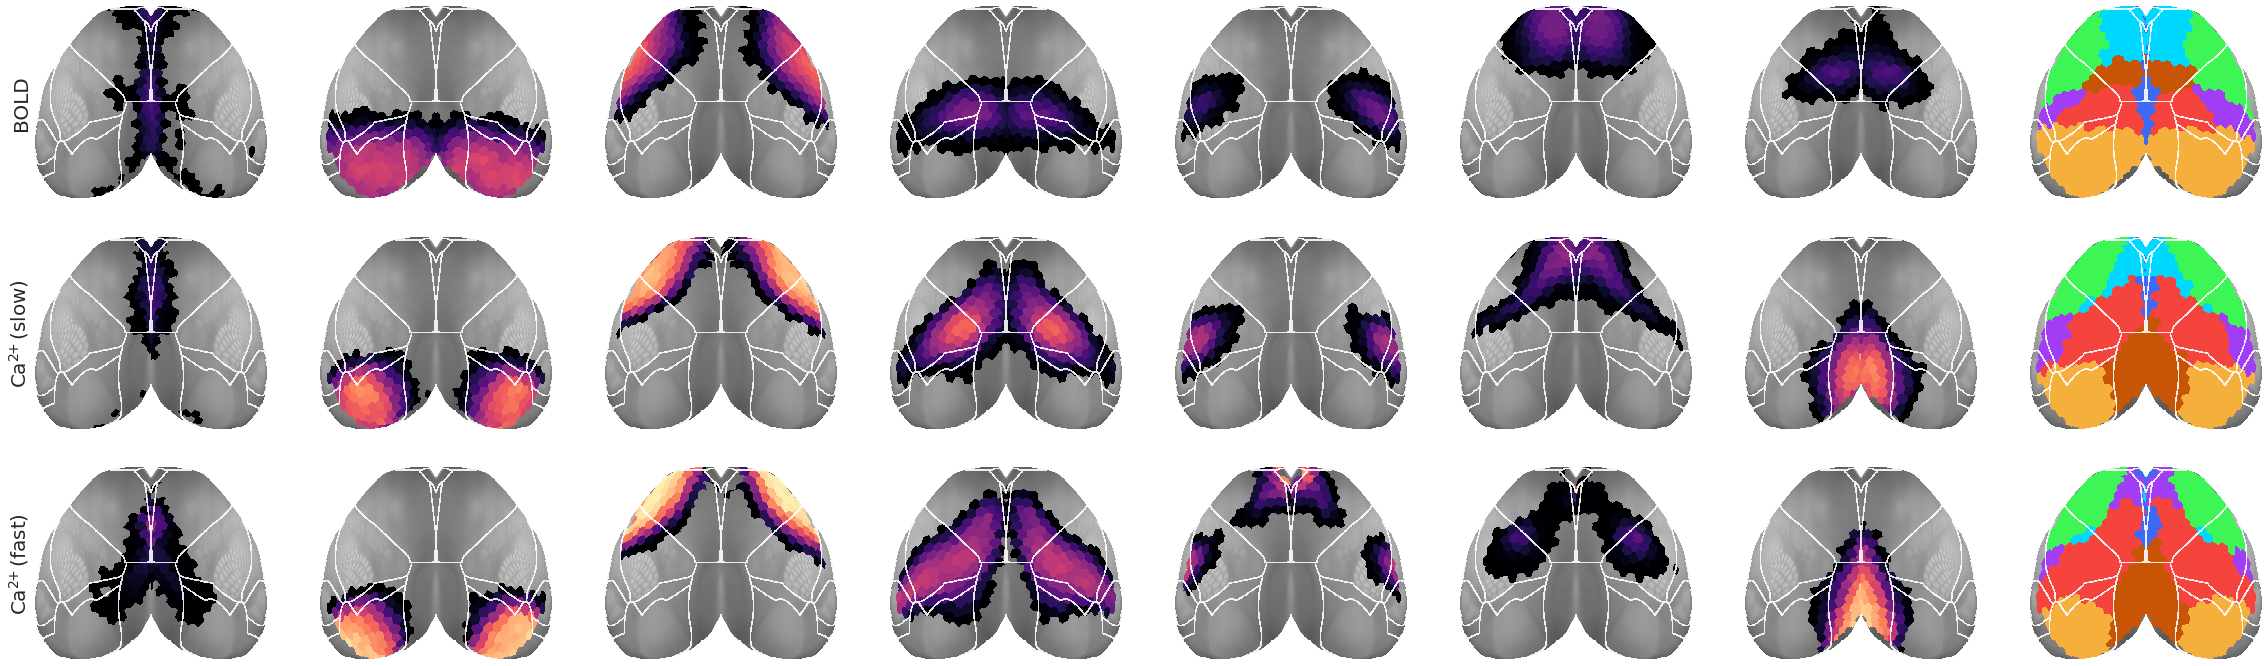

In [26]:
kws_show['figsize'] = (40, 12)
_ = bt.show(
    data=pi_sorted,
    **kws_show,
)

---
---

## MG (from before: old stuff)

In [9]:
thres = 0.372
bt_bo.run_pi, *_ = bt_bo._merge_vis(thres, bt_bo.run_pi)
bt_bo.pi_prune, *_ = bt_bo._merge_vis(thres, bt_bo.pi_prune)
bt_bo.num_k -= 1

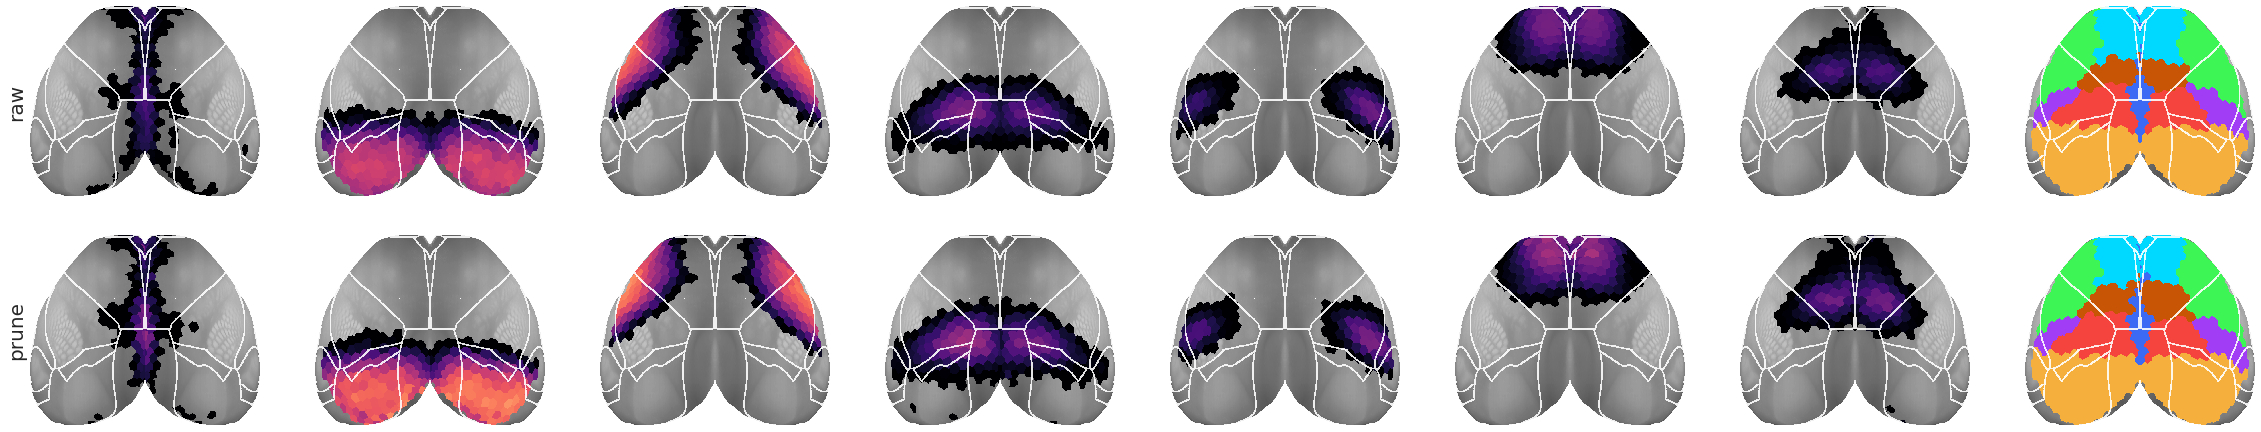

In [10]:
kws_show['figsize'] = (40, 7.7)
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

### Sort

In [11]:
pi_dict = {
    mode: avg(o.run_pi) for
    mode, o in bt_dict.items()
}
pi_sorted, gmaps = sort_communities(
    pi_dict=pi_dict,
    label_keys={'bold': _BOLD, 'cas': _CAS, 'caf': _CAF},
    global_order=('infer', False),
    match_metric='correlation',
    bold_as_src=True,
)

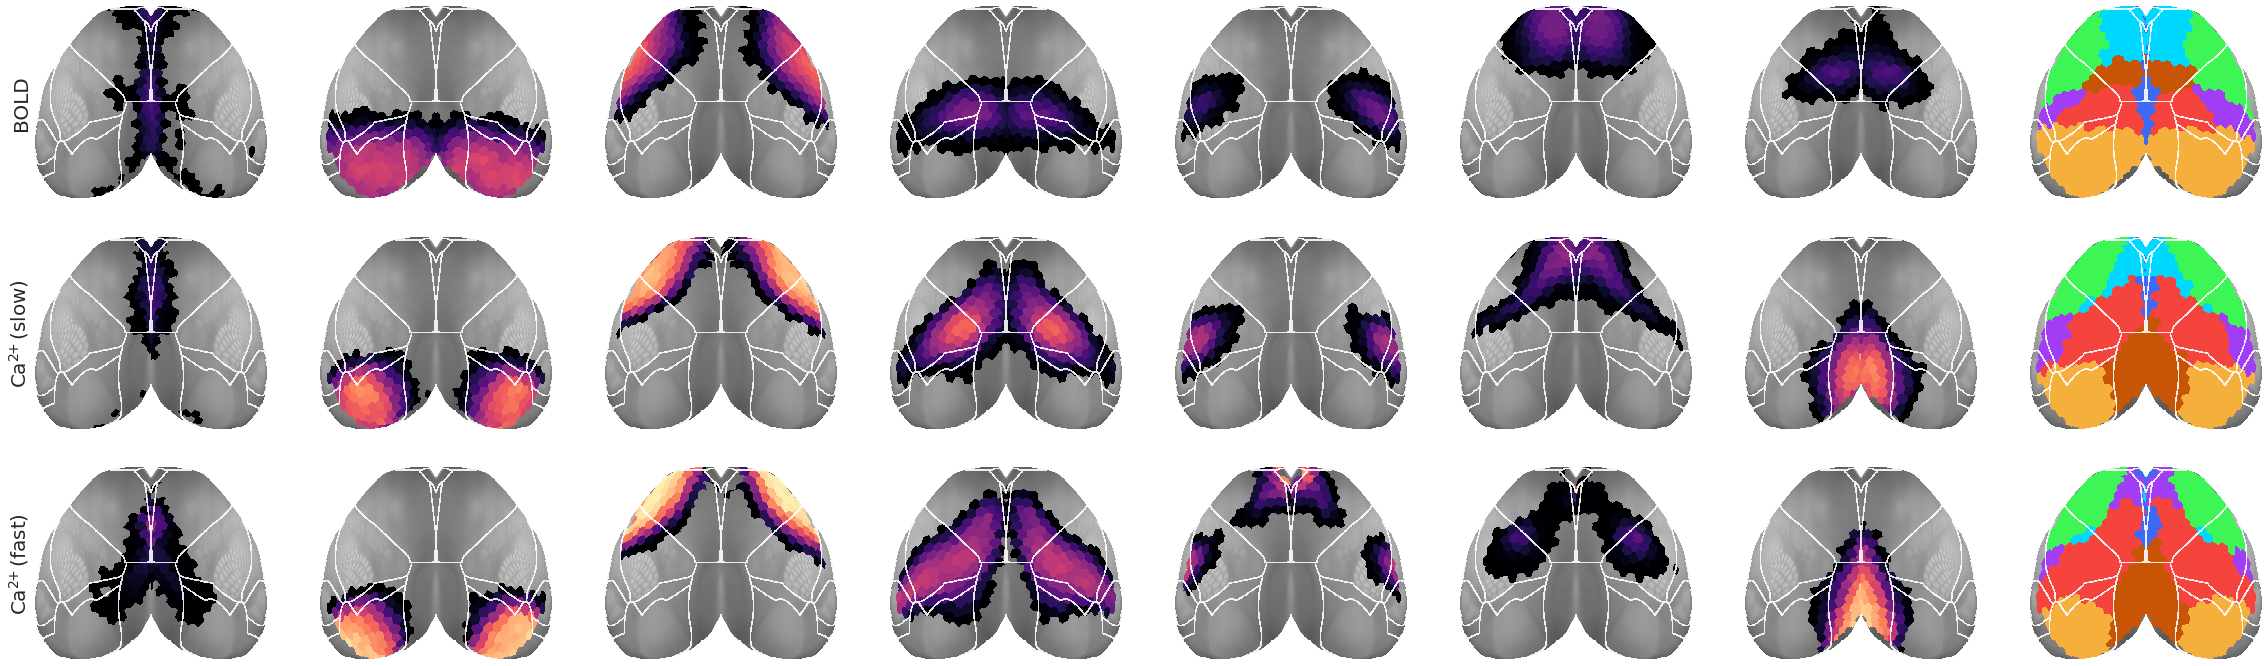

In [12]:
kws_show['figsize'] = (40, 12)
_ = bt.show(
    data=pi_sorted,
    **kws_show,
)

( BOLD  /  Ca$^{2\!\!+}$(slow) ) vs. ( BOLD  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = 0.057;  pval = 0.000000200000

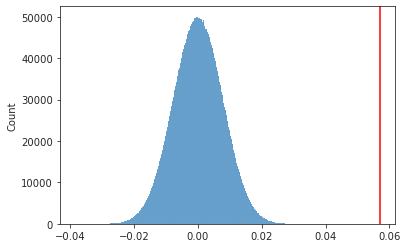

( BOLD  /  Ca$^{2\!\!+}$(slow) ) vs. ( Ca$^{2\!\!+}$(slow)  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = -0.182;  pval = 0.000000200000

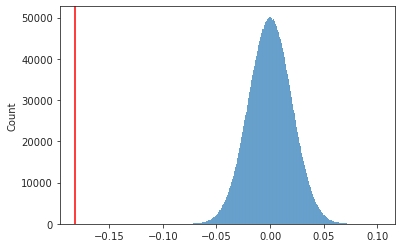

( BOLD  /  Ca$^{2\!\!+}$(fast) ) vs. ( Ca$^{2\!\!+}$(slow)  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = -0.239;  pval = 0.000000200000

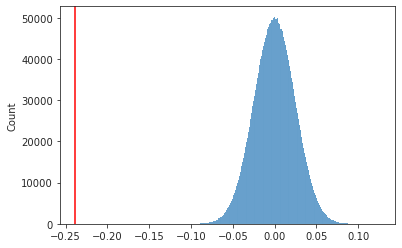

CPU times: user 3h 9min 49s, sys: 6.66 s, total: 3h 9min 56s
Wall time: 3h 9min 56s


In [224]:
%%time

for ii, jj in itertools.combinations(range(3), 2):
    cond_1, vals_1 = list(data4perm.items())[ii]
    cond_2, vals_2 = list(data4perm.items())[jj]

    test = sp_stats.permutation_test(
        data=(vals_1, vals_2),
        statistic=statistic,
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(1e7),
        random_state=42,
        batch=5,
    )
    msg = f"( {cond_1[0]}  /  {cond_1[1]} ) vs. ( {cond_2[0]}  /  {cond_2[1]} )\n"
    msg += f"pval = {test.pvalue:1.3e};  statistic = {test.statistic:.3f};  pval = {test.pvalue:0.12f}\n"
    print(msg)
    
    sns.histplot(test.null_distribution)
    plt.axvline(test.statistic, color='r')
    plt.show()

In [229]:
reject, pvals, *_ = multipletests([2e-7] * 3, method='fdr_bh')
reject.sum()

3

## Make column plots

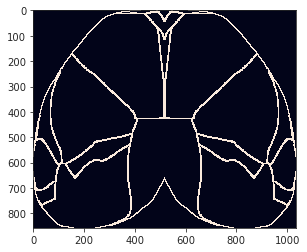

In [271]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

In [272]:
mask_thres = 1 / num_k
vmin = 0.2
vmax = 1.0
cbar = False
cmap = 'magma'
interp = 'antialiased'

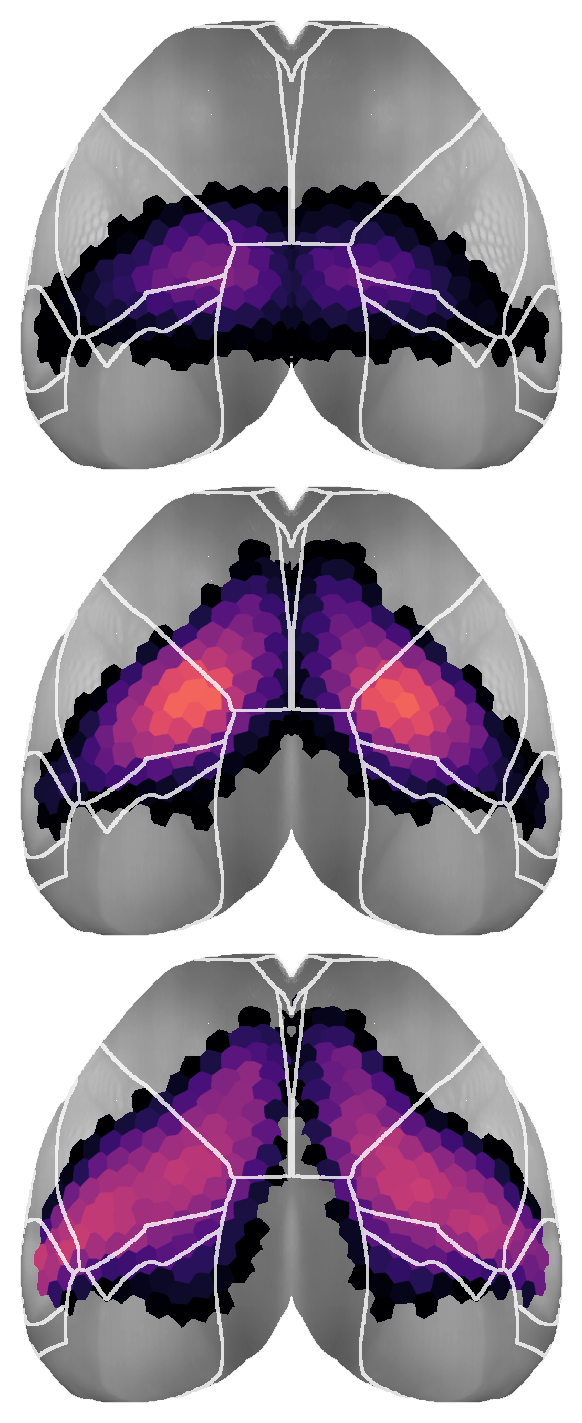

In [274]:
fig, axes = create_figure(
    nrows=3,
    ncols=1,
    figsize=(3, 7),
    sharex='all',
    sharey='all',
    tight_layout=False,
    constrained_layout=True,
    dpi=200,
)
i = 3
for j, (mode, pi) in enumerate(pi_sorted.items()):
    x = pi[i]
    x[x < mask_thres] = np.nan
    
    ax = axes[j]
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        cbar=cbar,
        interp=interp,
        contour=contour,
    )
remove_ticks(axes)

## Contour why rough?

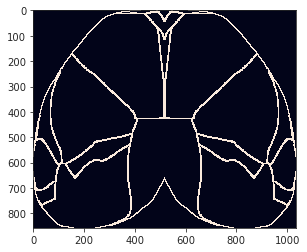

In [13]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

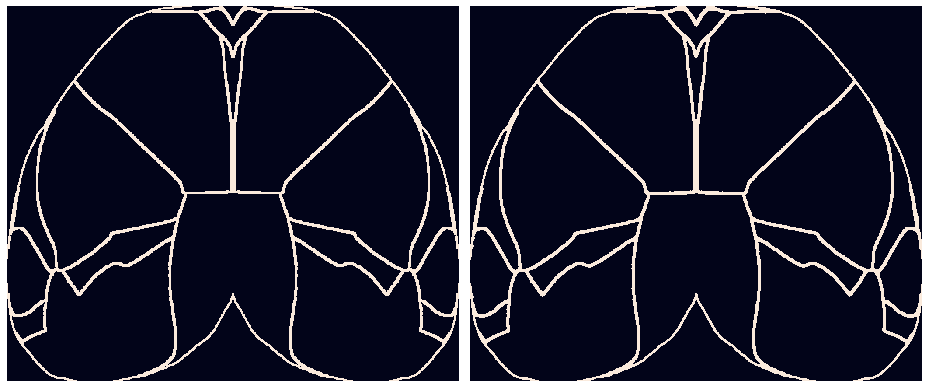

In [14]:
fig, axes = create_figure(1, 2, (13, 6))
axes[0].imshow(contour)

x = sp_img.median_filter(contour, 6)
# x = x > 0
axes[1].imshow(x)

remove_ticks(axes)

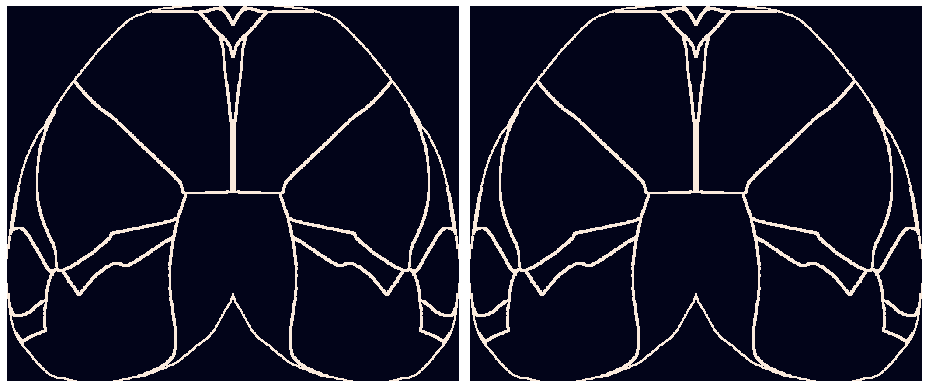

In [15]:
fig, axes = create_figure(1, 2, (13, 6))
axes[0].imshow(contour)

x = sp_img.gaussian_filter(contour, 0.1)
# x = x > 0
axes[1].imshow(x)

remove_ticks(axes)

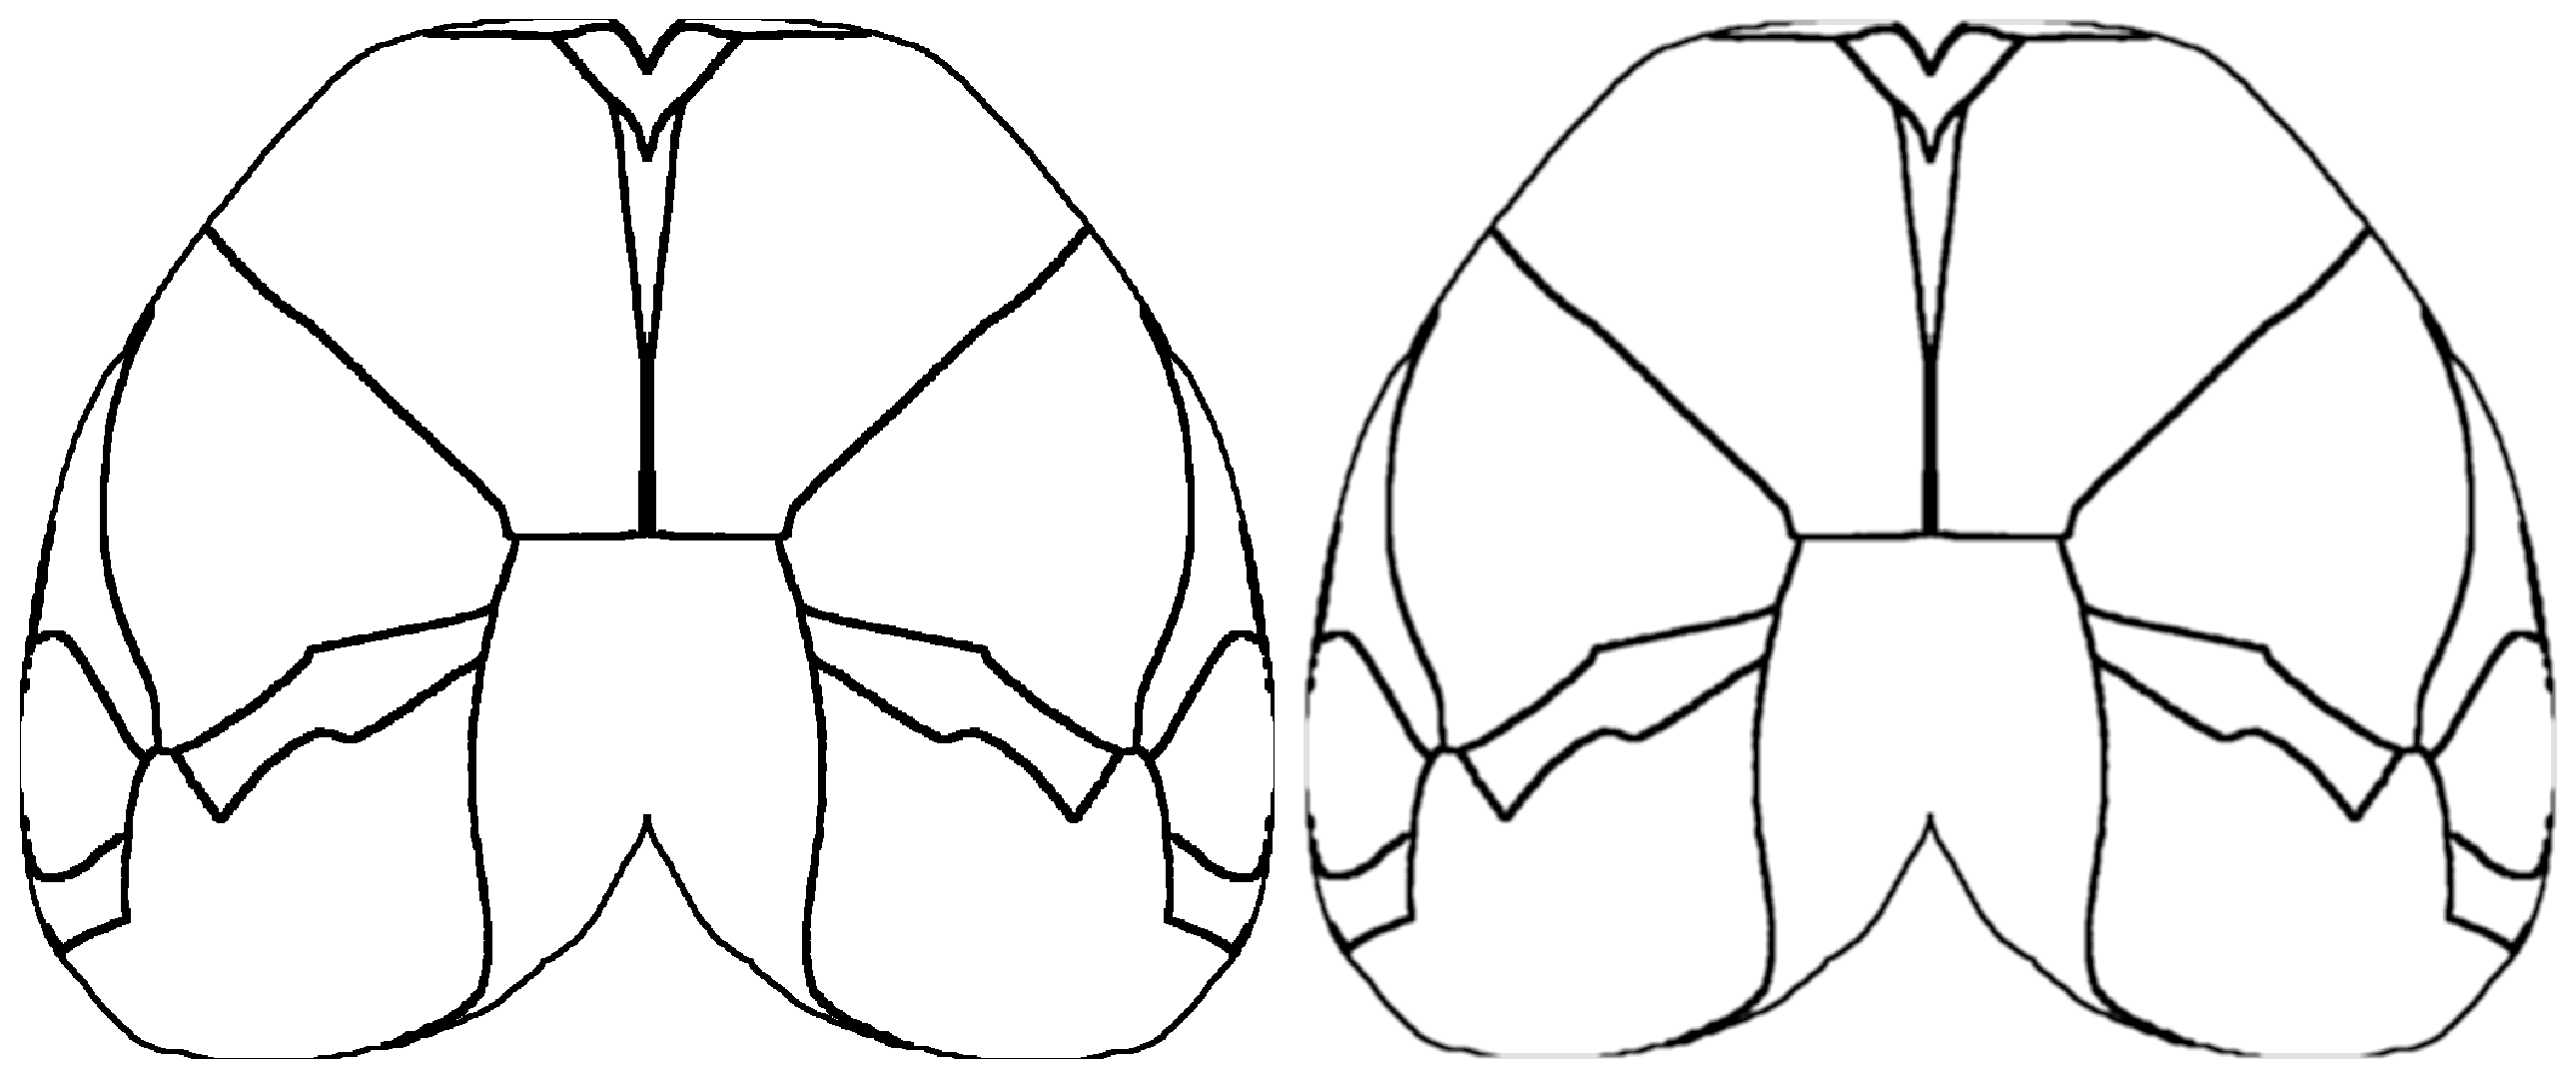

In [16]:
fig, axes = create_figure(1, 2, (13, 6), dpi=200)
axes[0].imshow(contour, cmap='Greys')

d = 5
x = sp_sig.convolve(contour, np.ones((d, d)))
# x = x > 0.01
axes[1].imshow(x, cmap='Greys')

remove_ticks(axes)

In [17]:
self = bt
if self.topview is None:
    _ = self.load_top_flat()
if self.affil is None:
    _ = self.node_affiliations()
obj = self.affil['obj_top'].copy()

width = 0.2
coarse = True

if coarse:
    subtree, _ = self.mice.al.get_subtree(315, 2, False)
    children = collections.defaultdict(list)
    nodes = [n.identifier for n in subtree.children(315)]
    nodes += [self.mice.al.get('SSp')['id']]
    for node in nodes:
        for child in subtree.children(node):
            children[node].append(child.identifier)

    for node, child_list in children.items():
        obj[np.isin(obj, child_list)] = node
contour = get_contour(obj, 0.125, width)

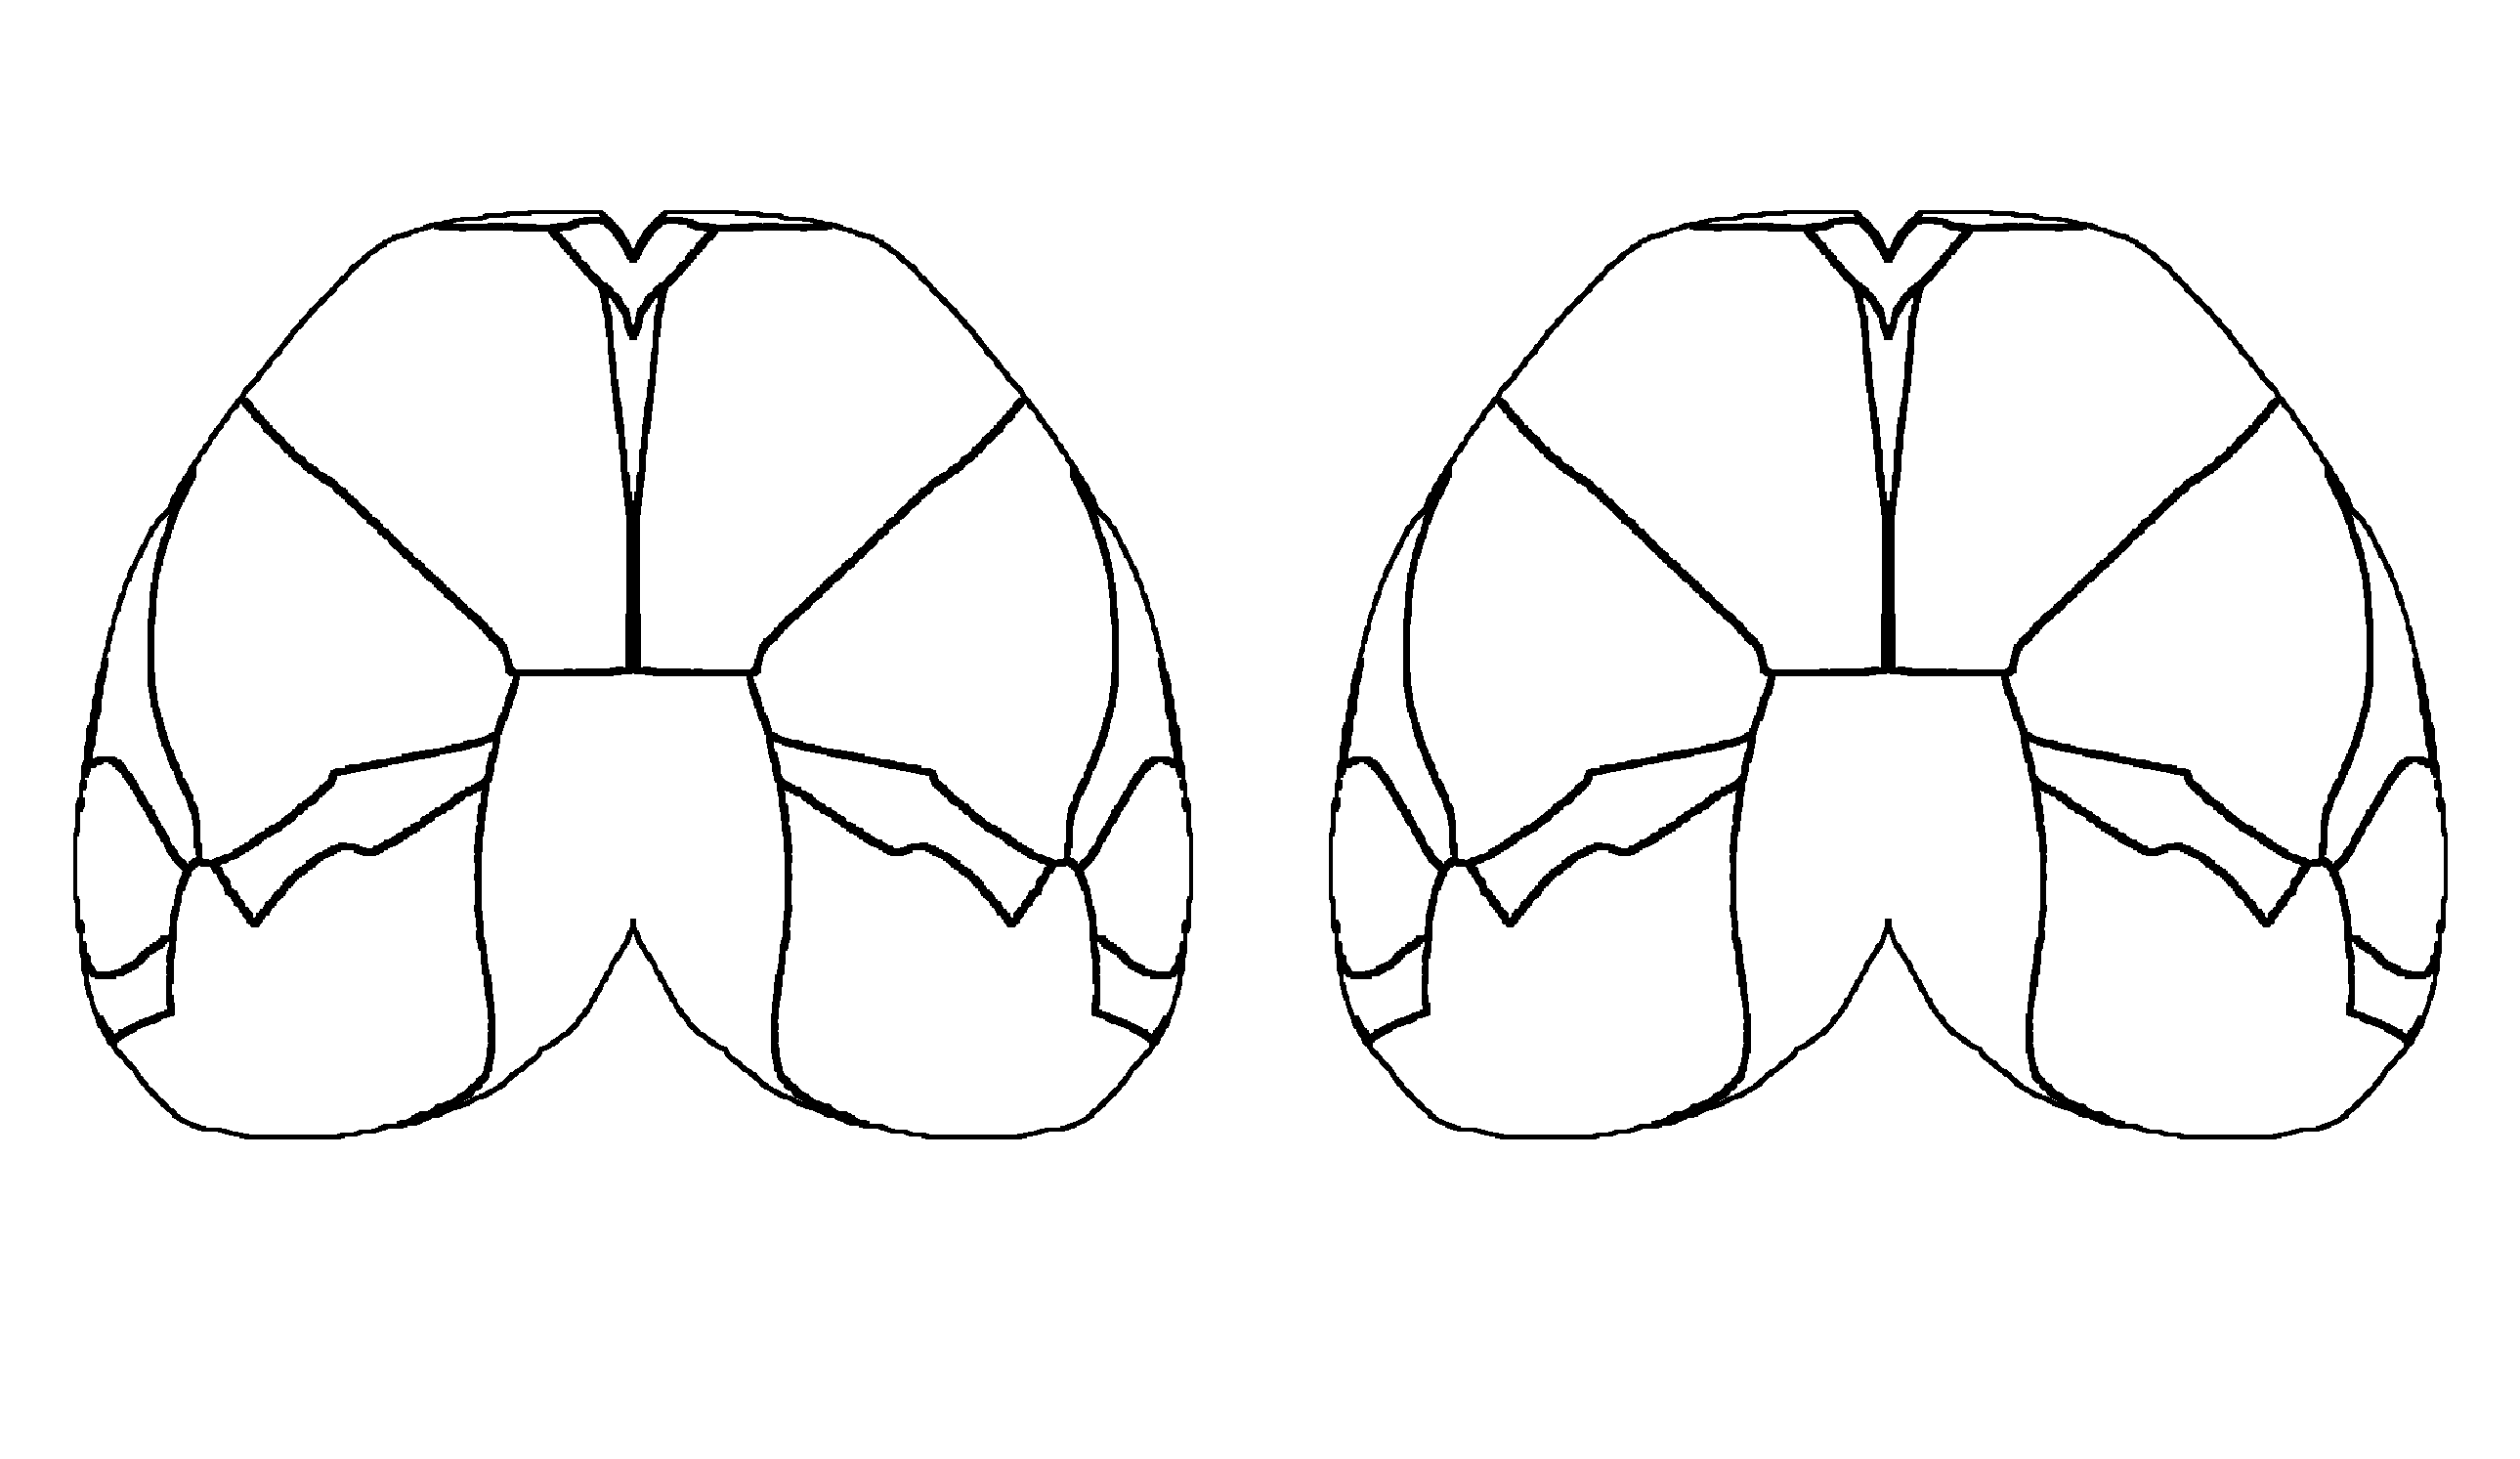

In [19]:
fig, axes = create_figure(1, 2, (13, 9), dpi=200)
axes[0].imshow(contour, cmap='Greys')

x = sp_img.gaussian_filter(contour, 0.1)
# x = x > 0.01
axes[1].imshow(x, cmap='Greys')

remove_ticks(axes)

In [56]:
interps = [
    'none', 'antialiased', 'nearest', 'bilinear',
    'bicubic', 'spline16', 'spline36', 'hanning',
    'hamming', 'hermite', 'kaiser', 'quadric', 'catrom',
    'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman',
]
len(interps)

19

In [57]:
fig, axes = create_figure(4, 5, (16, 14), 'all', 'all')
for i, e in enumerate(interps):
    ax = axes.flat[i]
    ax.imshow(mwh(bt.topview == 0, bt.topview), cmap='Greys_r')
    ax.imshow(mwh(contour == 0, contour), cmap='Greys', interpolation=e)
    ax.annotate(
        text=e,
        xy=(0.1, 0.1),
        xycoords='axes fraction',
        fontsize=13,
    )
trim_axs(axes, len(interps))

fig.savefig(pjoin(fig_dir, 'contour_interp.png'), dpi=1000, bbox_inches='tight')
plt.close()